# **Skin Cancer Detection**

#### **The problem**
From ISIC 2018: Skin Lesion Analysis Website [https://challenge2018.isic-archive.com]  


 > Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. The HAM10000 ("Human Against Machine with 10000 training images") dataset was collected by Tschandl, P., Rosendahl, C. and lots of different persons from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: 

**1. Actinic keratoses (akiec)**  
**2. basal cell carcinoma (bcc)**  
**3. benign keratosis-like lesions (bkl)**  
**4. dermatofibroma (df)**  
**5. melanoma (mel)**  
**6. melanocytic nevi (nv)**  
**7. vascular lesions (vasc)**

In this lab I will try to classify all seven different classes skin cancers using Convolution Neural Network with keras tensorflow in backend and then analyse the result to see how the model performance could be helpful in real world.


![](http://www.justscience.in/wp-content/uploads/2017/12/what-causes-skin-cancer.jpg)

#### Step1: Import Packages

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.utils import shuffle

In [3]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [4]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.15.0
Is GPU available: True
Is Eager Execution enabled?: False


#### Step2: Downloads Data
#### About HAM10000
This project will be using HAM10000 ("Human Against Machine with 10000 training images") dataset which is a collection of "dermatoscopic images from different populations, acquired and stored by different modalities."Kaggle This dataset has ~10K dermatoscopic images that have been reformatted to be similar smaller like the famous Handwritten Digit or MNIST dataset (64 x 64 images centered on the subject). This allows us to focus on setting up our environment and making sure we can get a model working on a more interesting, healthcare-related problem.

In [10]:
!pip install kaggle
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"joey1004","key":"3a7926f8f05b07f460a5c7ecc3c26c19"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [12]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [13]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list -s cancer

ref                                                   title                                           size  lastUpdated          downloadCount  
----------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
xiaotawkaggle/inhibitors                              Cancer Inhibitors                              104MB  2019-11-14 06:48:37           2880  
kmader/skin-cancer-mnist-ham10000                     Skin Cancer MNIST: HAM10000                      5GB  2018-09-20 20:36:13          18863  
piotrgrabo/breastcancerproteomes                      Breast Cancer Proteomes                          5MB  2019-11-14 05:15:12           7496  
loveall/cervical-cancer-risk-classification           Cervical Cancer Risk Classification              9KB  2017-08-31 01:02:22          10916  
uciml/breast-cancer-wisconsin-data                    Breast Cancer Wisconsin (Diagnostic) Data Set   49KB  2016-09-25 10:49:04   

In [14]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p data/

100% 5.20G/5.20G [01:38<00:00, 83.1MB/s]
100% 5.20G/5.20G [01:38<00:00, 56.5MB/s]


In [15]:
!unzip data/skin-cancer-mnist-ham10000.zip -d data/

Archive:  data/skin-cancer-mnist-ham10000.zip
  inflating: data/HAM10000_images_part_1/ISIC_0024306.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024307.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024308.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024309.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024310.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024311.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024312.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024313.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024314.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024315.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024316.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024317.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024318.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024319.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024320.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024321.

#### Step3: Reading Data

In [0]:
base_skin_dir = os.path.join('data')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [17]:
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Create some new columns (path to image, human-readable name) and review them

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['lesion_type'] = df['dx'].map(lesion_type_dict.get) 
df['lesion_type_idx'] = pd.Categorical(df['lesion_type']).codes
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,lesion_type,lesion_type_idx
8087,HAM_0000135,ISIC_0030362,nv,histo,25.0,female,lower extremity,data/HAM10000_images_part_2/ISIC_0030362.jpg,Melanocytic nevi,4
2437,HAM_0004409,ISIC_0027888,vasc,consensus,40.0,male,trunk,data/ham10000_images_part_1/ISIC_0027888.jpg,Vascular lesions,6
900,HAM_0006009,ISIC_0026174,bkl,consensus,65.0,male,face,data/ham10000_images_part_1/ISIC_0026174.jpg,Benign keratosis,2
3830,HAM_0003210,ISIC_0030237,nv,follow_up,45.0,female,upper extremity,data/HAM10000_images_part_2/ISIC_0030237.jpg,Melanocytic nevi,4
7565,HAM_0003325,ISIC_0034190,nv,histo,20.0,female,neck,data/HAM10000_images_part_2/ISIC_0034190.jpg,Melanocytic nevi,4


In [37]:
print(df.groupby(['dx','lesion_type','lesion_type_idx']).size())

dx     lesion_type           lesion_type_idx
akiec  Actinic keratoses     0                   327
bcc    Basal cell carcinoma  1                   514
bkl    Benign keratosis      2                  1099
df     Dermatofibroma        3                   115
mel    Melanoma              5                  1113
nv     Melanocytic nevi      4                  6705
vasc   Vascular lesions      6                   142
dtype: int64


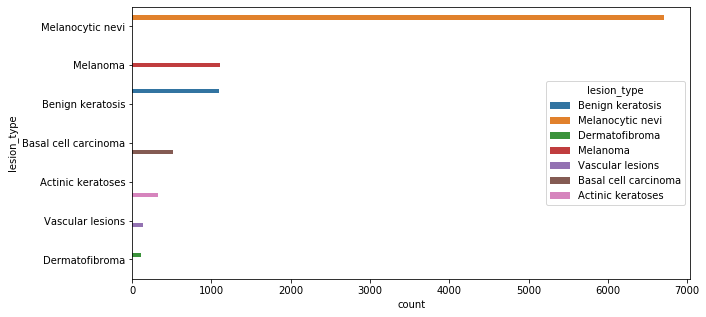

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(y='lesion_type', data=df, hue='lesion_type',order = df['lesion_type'].value_counts().index, ax= ax1)

#### 3.1 Data Cleaning

In [0]:
df.isnull().sum()

lesion_id           0
image_id            0
dx                  0
dx_type             0
age                57
sex                 0
localization        0
path                0
lesion_type         0
lesion_type_idx     0
dtype: int64

In [0]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [0]:
df.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age                0
sex                0
localization       0
path               0
lesion_type        0
lesion_type_idx    0
dtype: int64

#### 3.2 Data Oversampling and Undersampling 

In [0]:
num_sample = 800

df_df = (df.loc[df['dx']=='df']).sample(num_sample, replace = True)
df_vasc = (df.loc[df['dx']=='vasc']).sample(num_sample, replace = True)
df_akiec = (df.loc[df['dx'] == "akiec"]).sample(num_sample,replace = True)
df_bcc = df.loc[df['dx'] == "bcc"][0:num_sample].sample(num_sample,replace = True)
df_bkl = df.loc[df['dx'] == "bkl"][0:num_sample].sample(num_sample) 
df_mel = df.loc[df['dx'] == "mel"][0:num_sample].sample(num_sample)
df_nv = df.loc[df['dx'] == "nv"][0:num_sample].sample(num_sample)

skin_df = pd.concat([df_akiec, df_bcc, df_bkl, df_df, df_mel, df_nv, df_vasc])
skin_df = shuffle(skin_df)

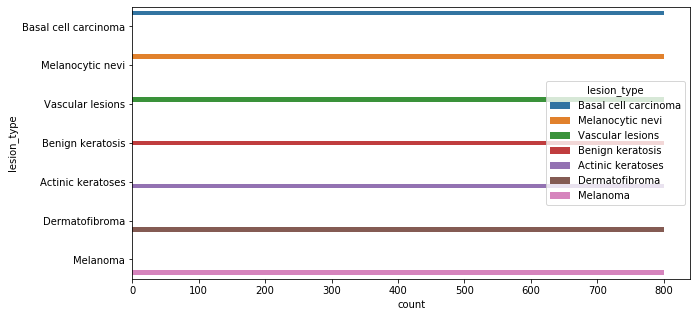

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y = 'lesion_type', data = skin_df, hue='lesion_type', ax = ax1)

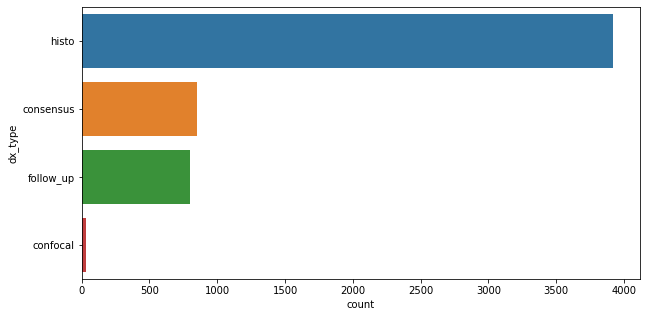

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y = 'dx_type', data = skin_df, order = skin_df['dx_type'].value_counts().index, ax = ax1)

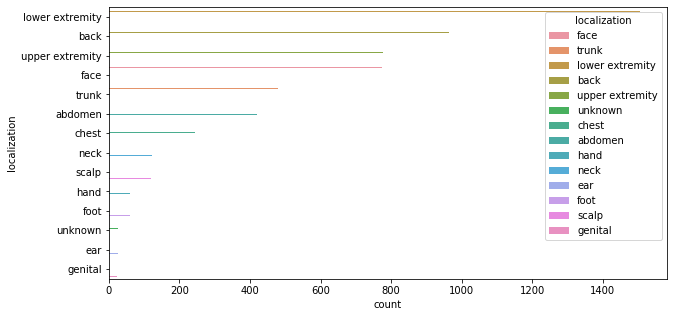

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y = 'localization', data = skin_df, hue='localization', order = skin_df['localization'].value_counts().index, ax = ax1)

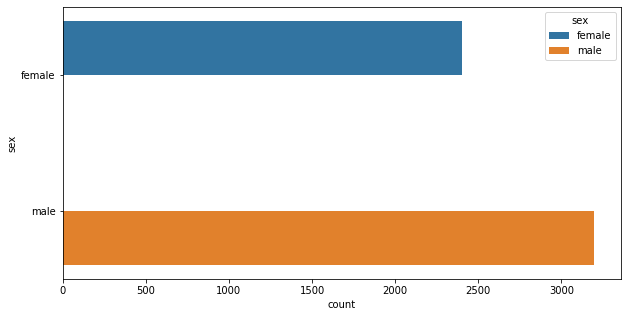

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y = 'sex', data = skin_df, hue='sex', ax = ax1)

#### 3.3 Import and resize images

In [0]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [41]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    5600
Name: image, dtype: int64

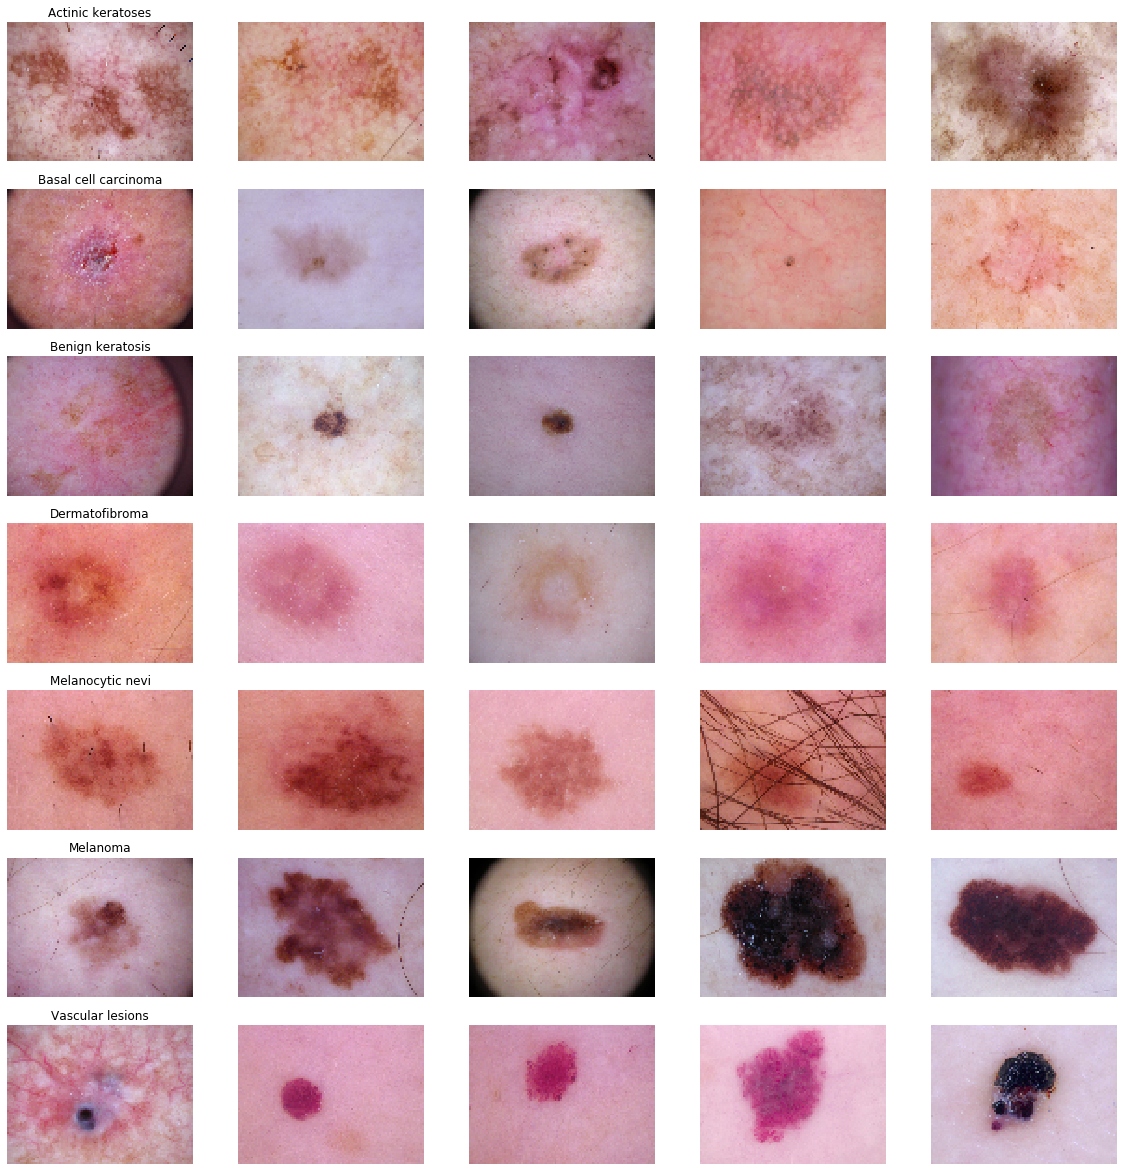

In [0]:
n_cols = 5
fig, m_axs = plt.subplots(7, n_cols, figsize = (4 * n_cols, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['lesion_type']).groupby('lesion_type')):
  n_axs[0].set_title(type_name)
  for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_cols, random_state=2019).iterrows()):
    c_ax.imshow(c_row['image'])
    c_ax.axis('off')
fig.savefig('categorical_samples.png', dpi = 300)

#### 3.4 Color channel analysis
  How do the narmalized color samples vary across different types of skin diseases?

In [63]:
rgb_info_df = skin_df.apply(lambda x: pd.Series({
    '{}_mean'.format(k): v for k, v in zip(['Red', 'Green', 'Blue'], np.mean(x['image'],(0, 1)))
}), 1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
  rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(10)

,Red_mean,Green_mean,Blue_mean,Gray_mean
2398,1.034012,0.909668,1.056320,197.068444
2374,1.134106,0.903276,0.962618,175.930844
3541,1.304124,0.825151,0.870725,168.870711
3508,1.389414,0.837209,0.773377,164.699200
1713,1.133403,0.916176,0.950420,158.248133
2445,1.312754,0.775037,0.912209,142.829600
1481,1.104202,0.898374,0.997424,134.143200
2386,1.038261,0.894985,1.066754,190.064356
10003,1.131128,0.882099,0.986772,145.026622
2350,1.113458,0.915481,0.971061,168.083156


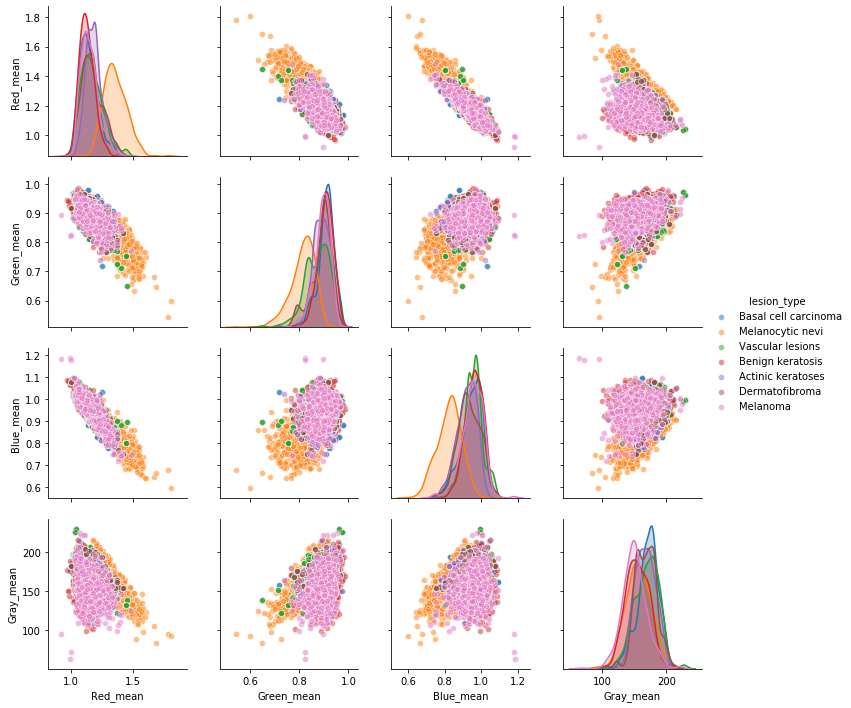

In [65]:
for c_col in rgb_info_df.columns:
  skin_df[c_col] = rgb_info_df[c_col].values

sns.pairplot(skin_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'lesion_type']],
             hue = 'lesion_type', plot_kws = {'alpha': 0.5})

The plot above showed that, Melanocytic nevi always appears an obvious wider range of rgb distribution. 

#### Step4: Train Test Split

In [0]:
features=skin_df.drop(columns=['lesion_type_idx'],axis=1)
target=skin_df['lesion_type_idx']

from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=1234)

#### Normalization and Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these labels to one hot vectors.

In [0]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [44]:
y_train_o.value_counts() # should change to count numbers directly

4    613
5    607
2    601
3    599
0    597
6    593
1    590
Name: lesion_type_idx, dtype: int64

In [45]:
y_test_o.value_counts()

1    210
6    207
0    203
3    201
2    199
5    193
4    187
Name: lesion_type_idx, dtype: int64

#### Splitting training and validation split
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [0]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2019)

In [0]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

#### Step5: Model 
#### Design Parameters


In [49]:
input_shape = (75, 100, 3) 
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 73, 98, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 71, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 48, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 48, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 107520)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               13762688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [0]:
from keras import backend as K

def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer = 'adam',loss=keras.losses.categorical_crossentropy,
              metrics=['acc', recall, precision, f1])


In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [59]:
batch_size = 15
epochs = 20

history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0],
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0],
    callbacks=[learning_rate_reduction]
)


Epoch 1/20
3780/3780 [==============================] - 147s 39ms/step - loss: 0.4774 - acc: 0.8289 - recall: 0.7859 - precision: 0.8689 - f1: 0.8238 - val_loss: 0.6285 - val_acc: 0.8738 - val_recall: 0.8619 - val_precision: 0.8905 - val_f1: 0.8756
Epoch 2/20
3780/3780 [==============================] - 147s 39ms/step - loss: 0.4235 - acc: 0.8480 - recall: 0.8143 - precision: 0.8828 - f1: 0.8459 - val_loss: 0.5959 - val_acc: 0.8476 - val_recall: 0.8310 - val_precision: 0.8606 - val_f1: 0.8450
Epoch 3/20
3780/3780 [==============================] - 147s 39ms/step - loss: 0.3852 - acc: 0.8632 - recall: 0.8338 - precision: 0.8927 - f1: 0.8612 - val_loss: 0.6366 - val_acc: 0.8619 - val_recall: 0.8595 - val_precision: 0.8728 - val_f1: 0.8658
Epoch 4/20
3780/3780 [==============================] - 148s 39ms/step - loss: 0.3686 - acc: 0.8710 - recall: 0.8437 - precision: 0.8968 - f1: 0.8685 - val_loss: 0.6308 - val_acc: 0.8810 - val_recall: 0.8786 - val_precision: 0.8954 - val_f1: 0.8866
Epoc

### Model Evaluation

In [60]:
loss, accuracy, precision, recall, F1_score = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v, precision_v, recall_v, F1_score_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f; loss = %f; precision = %f; recall = %f;  F1 score = %f " % (accuracy_v, loss_v, precision_v, recall_v, F1_score_v))
print("Test: accuracy = %f; loss = %f; precision = %f; recall = %f;  F1 score = %f " % (accuracy, loss, precision, recall, F1_score))

420/420 [==============================] - 0s 295us/step
Validation: accuracy = 0.895238; loss = 0.761020; precision = 0.895238; recall = 0.901767;  F1 score = 0.898450 
Test: accuracy = 0.883571; loss = 0.701700; precision = 0.875714; recall = 0.892384;  F1 score = 0.883885 


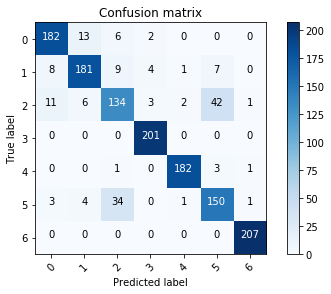

In [61]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

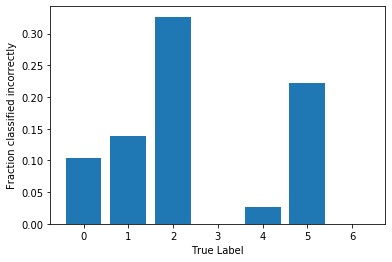

In [62]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### **Conclusion**
As plot above illustrated,our model has maximum number of incorrect predictions for Benign Ceratosis code 2 then Melanoma code 5, where as Vascular Lesions code 6 and Dermatofibroma code 3 has least misclassified type.

Our model has achieve the accuracy and recall both above 89.5% with a robust F1 score 0.898, which is much more efficient in comparison to the detection with human eyes having 77.0344% accuracy.
